In [1]:
import torch
import numpy as np 
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Optimizer
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from useful_functions import *
from optimizer import *
from model import *
from MNIST_data_process import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from training import *
from mlxtend.data import mnist_data
from accuracy_compute import *
from data_preparation_easy import *
from data_preparation_hard import *
from network_func import *
from search_parameter import *
import optuna
from CIFAR10_model import *
from CIFAR10_data_preparation import *
from useful_model import *
import sys
sys.path.append('/root/GanLuo/PullSum_MNIST/code/神经网络实验')
from models_complex import *
from resnet_model import resnet18,resnet34,resnet50

In [2]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()  # 将模型设置为训练模式
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 计算训练损失和准确性
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    print(f"Train Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

# 测试循环
def test(model, device, test_loader, criterion):
    model.eval()  # 将模型设置为评估模式a
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():  # 在测试过程中不计算梯度
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # 计算准确性
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# 假设已经加载了 CIFAR-10 数据并准备好训练和测试数据
X_train, X_test, y_train, y_test = load_cifar10_data()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 将数据转换为 Tensor 并移动到设备 (GPU 或 CPU)
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

pretrained_weights_path = "/root/GanLuo/PullSum_MNIST/code/神经网络实验/state_dicts/resnet18.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=True, progress=False, device=device, pretrained_weights_path=pretrained_weights_path)
model.to(device)

lr = 1e-2
batch_size = 256
num_epochs = 50

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

# 创建数据加载器
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

L1,L2,A1,A2=[], [], [], []

# 运行训练和测试循环
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    Trian_loss,Trian_accuracy = train(model, device, train_loader, optimizer, criterion)
    Test_loss,Test_accuracy = test(model, device, test_loader, criterion)
    L1.append(Trian_loss)
    L2.append(Test_loss)    
    A1.append(Trian_accuracy)
    A2.append(Test_accuracy)

Epoch [1/50]
Train Loss: 0.0821, Accuracy: 97.78%
Test Loss: 0.4237, Accuracy: 88.06%
Epoch [2/50]
Train Loss: 0.0530, Accuracy: 98.73%
Test Loss: 0.7621, Accuracy: 79.73%
Epoch [3/50]
Train Loss: 0.0351, Accuracy: 99.28%
Test Loss: 0.5095, Accuracy: 86.40%
Epoch [4/50]
Train Loss: 0.0195, Accuracy: 99.76%
Test Loss: 0.5866, Accuracy: 84.68%
Epoch [5/50]
Train Loss: 0.0171, Accuracy: 99.79%
Test Loss: 0.2966, Accuracy: 92.44%
Epoch [6/50]
Train Loss: 0.0091, Accuracy: 99.98%
Test Loss: 0.3086, Accuracy: 92.05%
Epoch [7/50]
Train Loss: 0.0075, Accuracy: 99.99%
Test Loss: 0.2849, Accuracy: 92.80%
Epoch [8/50]
Train Loss: 0.0061, Accuracy: 100.00%
Test Loss: 0.2860, Accuracy: 92.71%
Epoch [9/50]
Train Loss: 0.0056, Accuracy: 100.00%
Test Loss: 0.2859, Accuracy: 92.68%
Epoch [10/50]
Train Loss: 0.0052, Accuracy: 100.00%
Test Loss: 0.2861, Accuracy: 92.79%
Epoch [11/50]
Train Loss: 0.0046, Accuracy: 100.00%
Test Loss: 0.2874, Accuracy: 92.77%
Epoch [12/50]
Train Loss: 0.0042, Accuracy: 100.

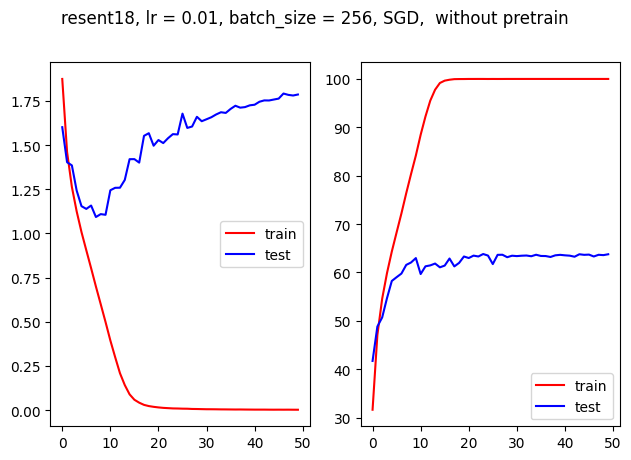

In [4]:
plt.subplot(1,2,1)
plt.plot(L1,color='r',label='train')
plt.plot(L2,color='b',label='test')
plt.legend()

plt.subplot(1,2,2)
plt.plot(A1,color='r',label='train')
plt.plot(A2,color='b',label='test')
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.90]) 
plt.suptitle(f'resent18, lr = {lr}, batch_size = {batch_size}, SGD,  without pretrain')
plt.show()

In [ ]:
plt.subplot(1,2,1)
plt.plot(L1,color='r',label='train')
plt.plot(L2,color='b',label='test')
plt.legend()

plt.subplot(1,2,2)
plt.plot(A1,color='r',label='train')
plt.plot(A2,color='b',label='test')
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.90]) 
plt.suptitle(f'resent18, lr = {lr}, batch_size = {batch_size}, SGD,  with pretrain')
plt.show()